# Predicting median household income for Neighborhoods in New York City

## Introduction¶
This file contains a selection of census data for different neighborhoods in the 5 boroughs of New York City for things like total population, racial/ethnic demographic information, employment and commuting characteristics, and more. This notebook will examine the census data in an attempt to build a model to predict median household income.

In [70]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

nyc_df = pd.read_csv('nyc_census_tracts.csv')
nyc_df.head()

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


## Data Cleaning¶
We will begin the Data Cleaning process by looking at the object types of our columns to see if there are any type errors with the data. Then we will proceed to check for missing data in the set.

In [71]:
nyc_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      2167 non-null   int64  
 1   County           2167 non-null   object 
 2   Borough          2167 non-null   object 
 3   TotalPop         2167 non-null   int64  
 4   Men              2167 non-null   int64  
 5   Women            2167 non-null   int64  
 6   Hispanic         2128 non-null   float64
 7   White            2128 non-null   float64
 8   Black            2128 non-null   float64
 9   Native           2128 non-null   float64
 10  Asian            2128 non-null   float64
 11  Citizen          2167 non-null   int64  
 12  Income           2101 non-null   float64
 13  IncomeErr        2101 non-null   float64
 14  IncomePerCap     2121 non-null   float64
 15  IncomePerCapErr  2121 non-null   float64
 16  Poverty          2125 non-null   float64
 17  ChildPoverty  

There are 36 columns and about 2400 rows in my data set. All the columns are of type integer or float, other than the County and Borough columns which are objects as expected. Let's see if we have any missing data.

In [72]:
nyc_df.isnull().sum()

CensusTract         0
County              0
Borough             0
TotalPop            0
Men                 0
Women               0
Hispanic           39
White              39
Black              39
Native             39
Asian              39
Citizen             0
Income             66
IncomeErr          66
IncomePerCap       46
IncomePerCapErr    46
Poverty            42
ChildPoverty       60
Professional       43
Service            43
Office             43
Construction       43
Production         43
Drive              43
Carpool            43
Transit            43
Walk               43
OtherTransp        43
WorkAtHome         43
MeanCommute        61
Employed            0
PrivateWork        43
PublicWork         43
SelfEmployed       43
FamilyWork         43
Unemployment       42
dtype: int64

It is evident from looking at the dataset and also seeing that a lot of the columns have the same or similar number of missing values that there are entire rows with missing data. As a result of this, we can drop the missing data rows without losing much information.

In [73]:
nyc_df = nyc_df.dropna()

#We actually don't learn anything from the County column as it is identical to the Borough column, so that can be removed.

nyc_df = nyc_df.drop(columns = 'County')

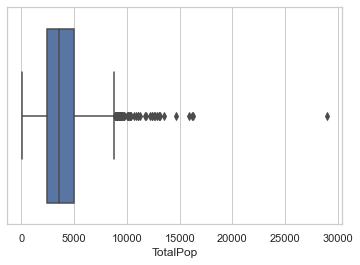

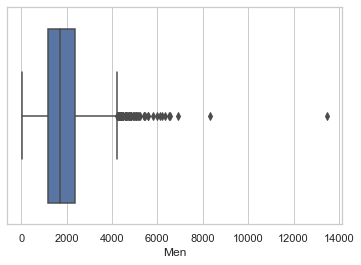

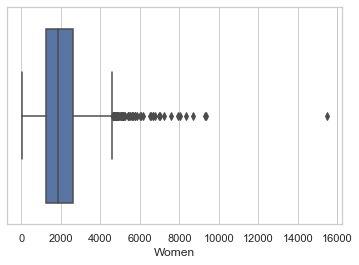

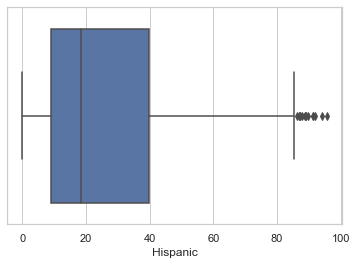

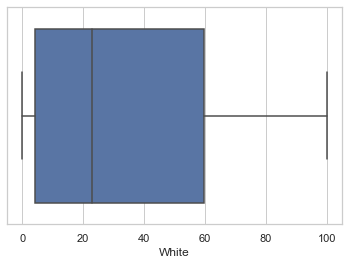

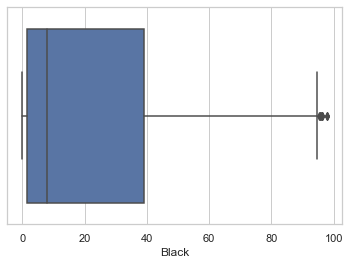

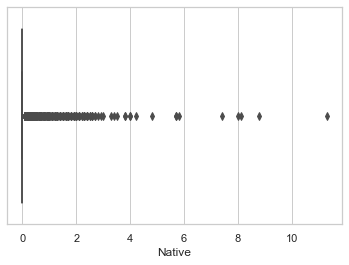

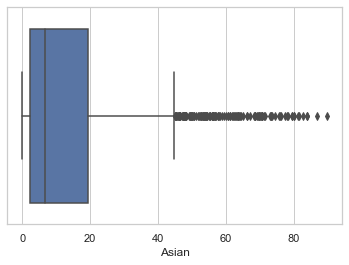

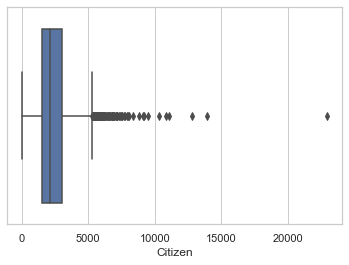

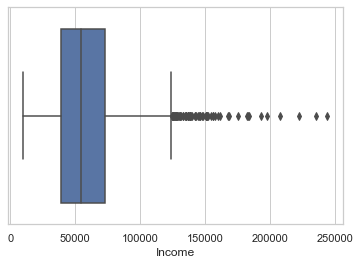

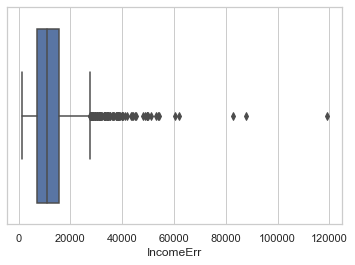

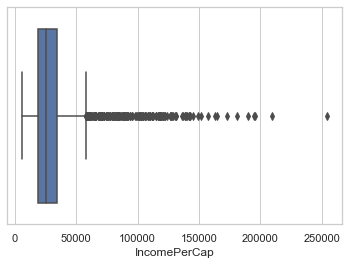

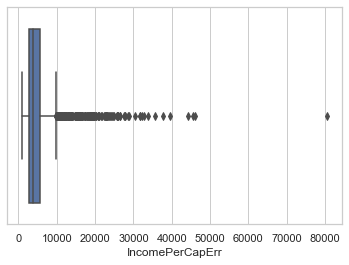

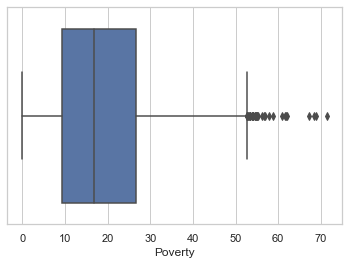

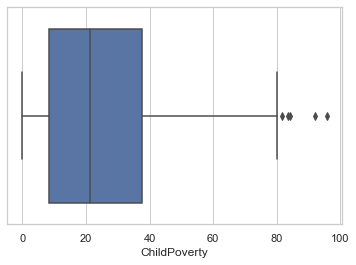

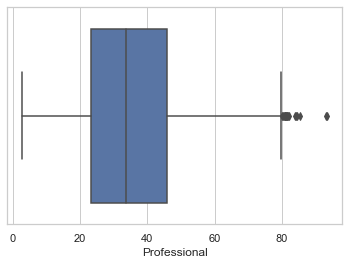

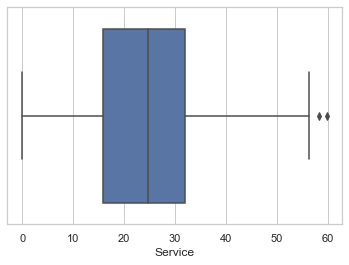

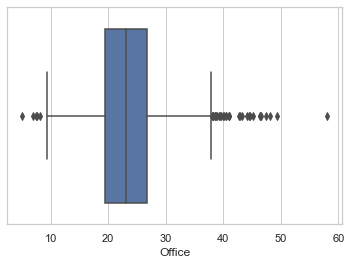

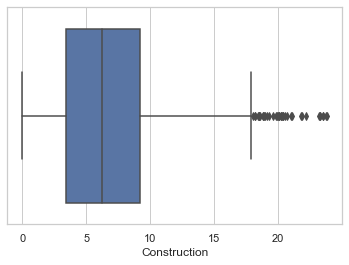

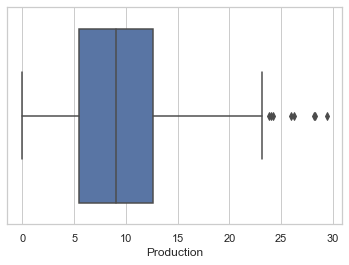

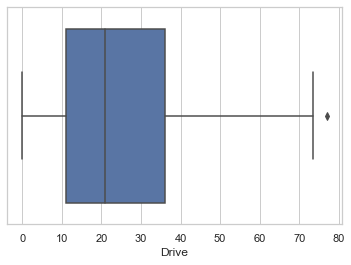

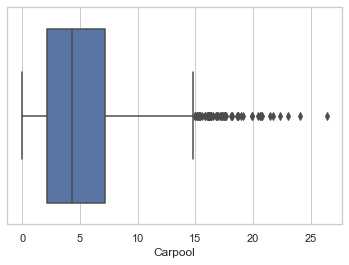

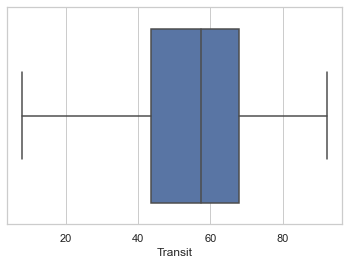

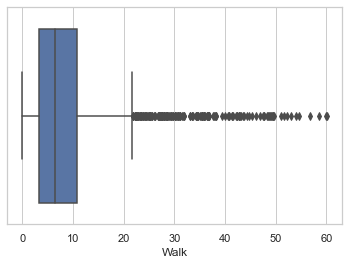

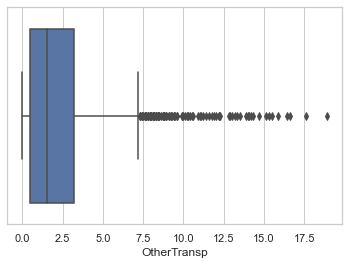

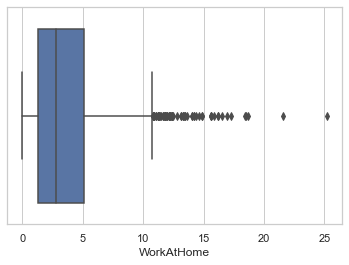

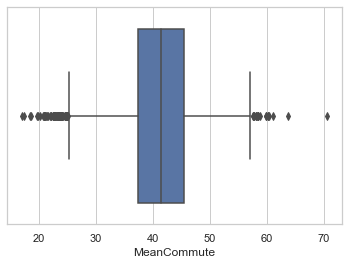

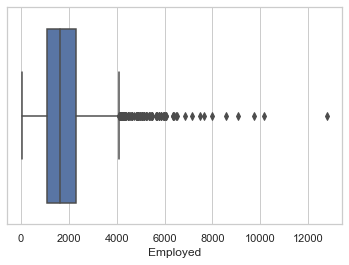

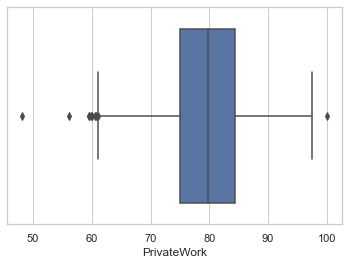

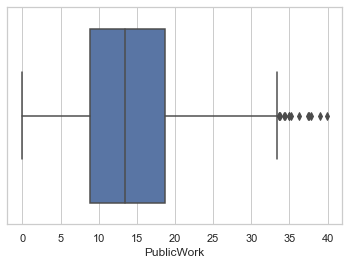

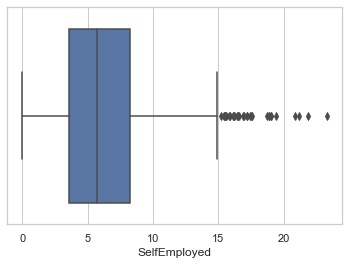

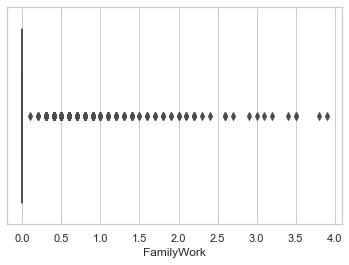

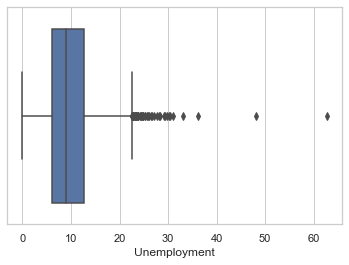

In [74]:
#Explore the data to check for outliers
columns = ['TotalPop', 'Men','Women','Hispanic','White','Black','Native','Asian', 
 'Citizen','Income','IncomeErr', 'IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service',
 'Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome',
 'MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment'
 ]


for column in columns:
    sns.boxplot(nyc_df[column])
    
    plt.show()

It appears there are no unreasonable outliers in our dataset and winsorization or other data cleaning methods are not necessary.



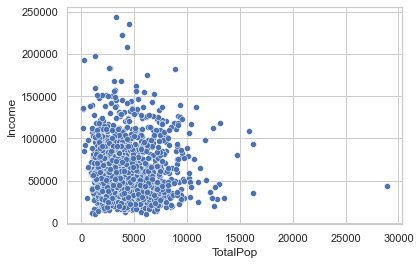

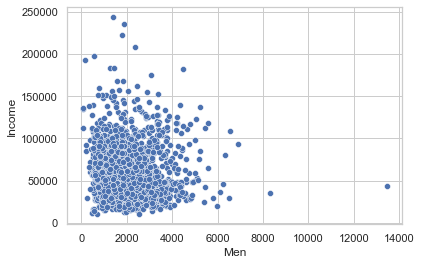

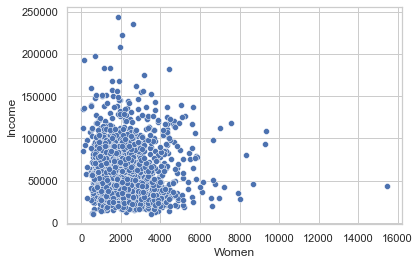

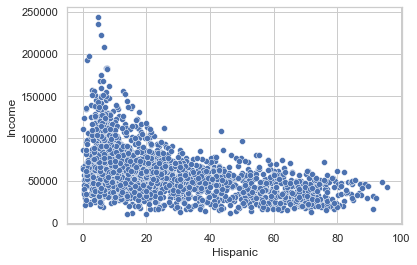

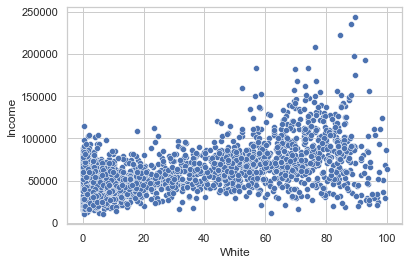

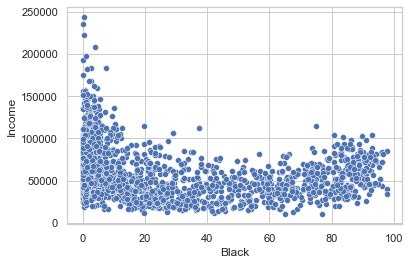

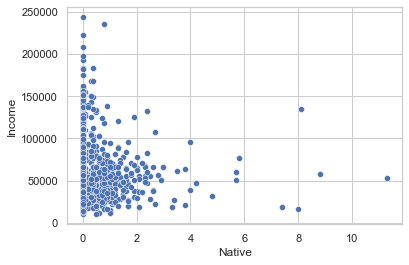

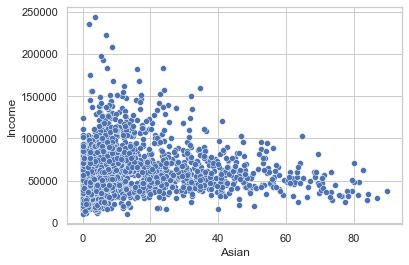

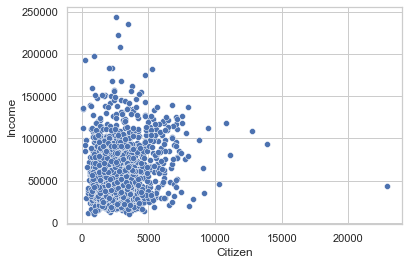

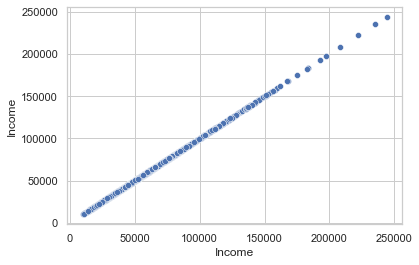

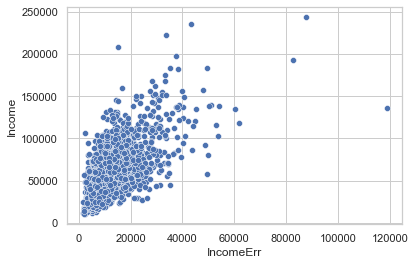

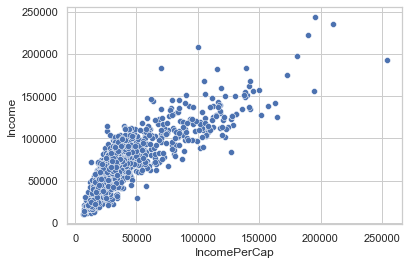

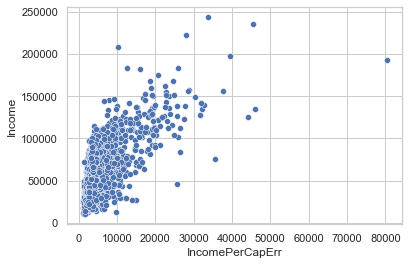

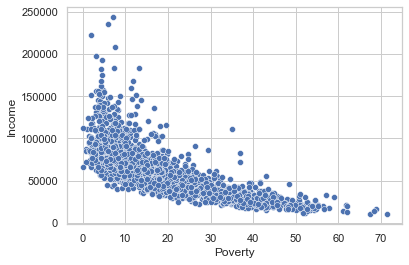

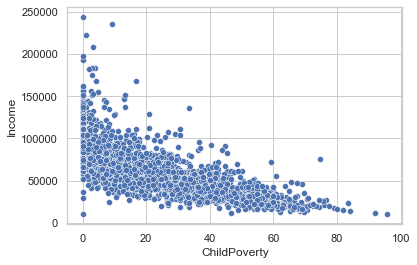

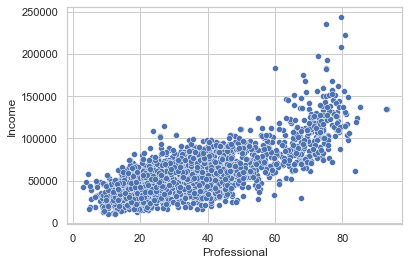

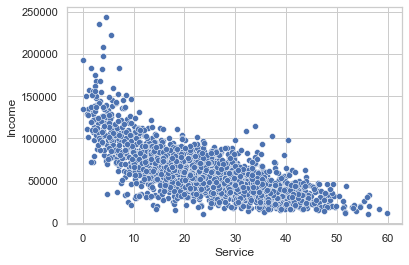

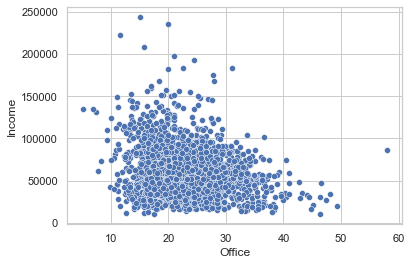

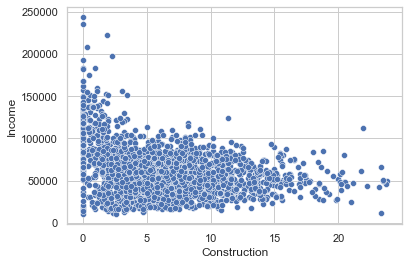

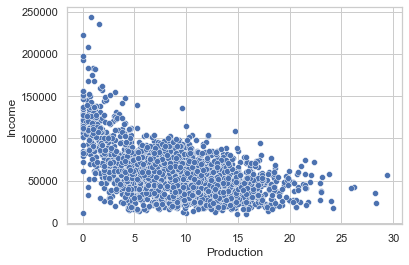

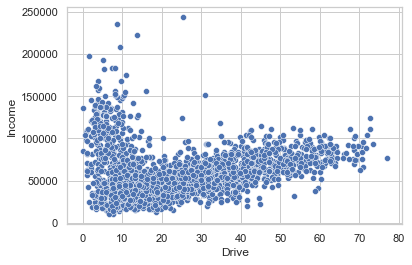

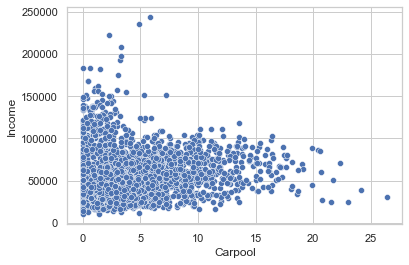

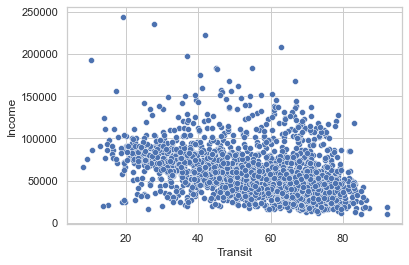

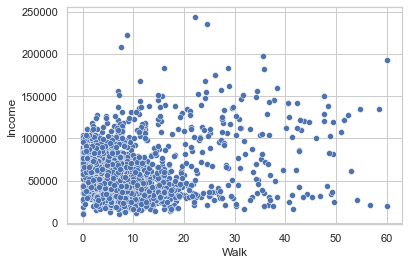

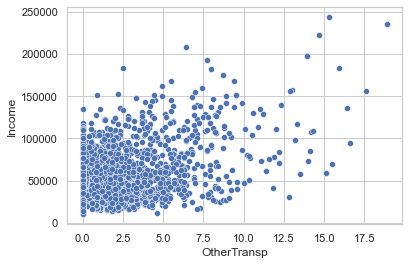

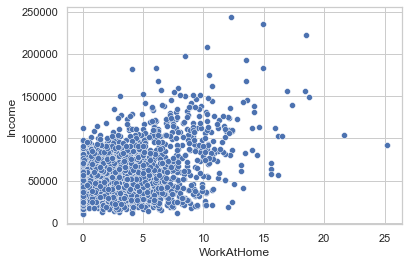

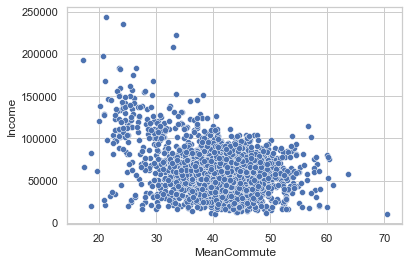

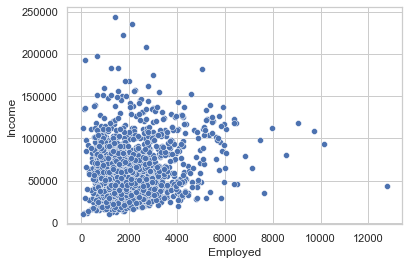

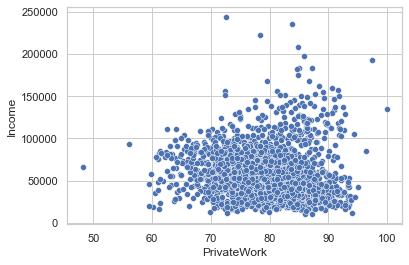

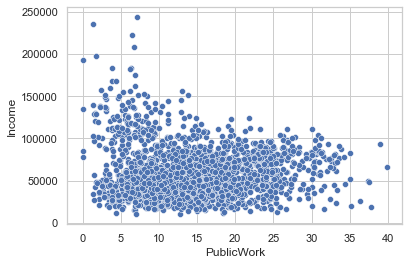

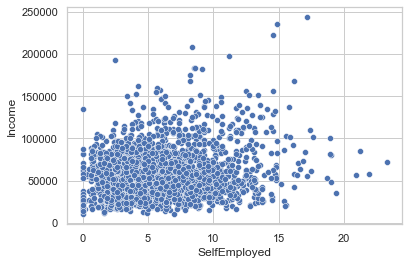

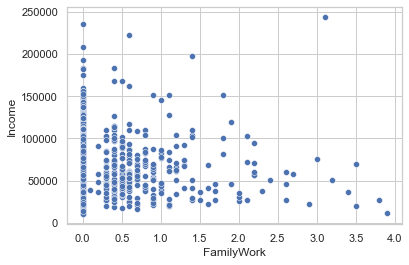

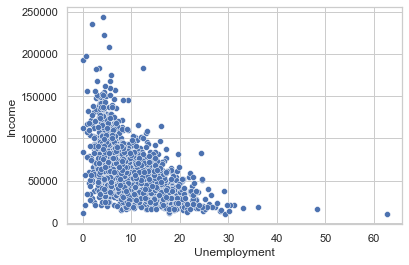

In [75]:
for column in columns:
    sns.scatterplot(nyc_df[column], nyc_df['Income'])
    plt.show()

Viewing the plots, it appears highly correlated variables with Median household income include Income Error, Income per Cap, Professional, White, and Self Employed. It is not surprising that income scores are highly correlated with their respective error scores, and this isn't really of interest to us in this experiment. As a result we will drop the error columns.

In [76]:
nyc_df = nyc_df.drop(columns = ['IncomePerCapErr','IncomeErr'])


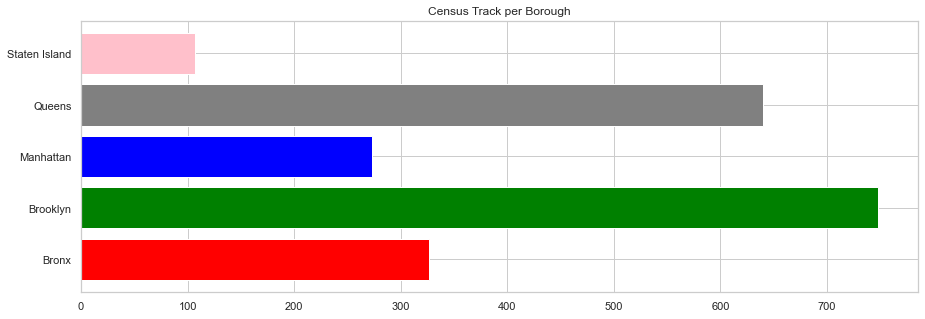

In [77]:
#Let's take a look to see the number of rows in each Borough
plt.figure(figsize=(15,5))
plt.barh(nyc_df.groupby("Borough")["Borough"].count().index, 
        nyc_df.groupby("Borough")["Borough"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("Census Track per Borough")

plt.show()

There appears to be a significant difference in the amount of data collected per borough, with Brooklyn having over double the amount of data as the Bronx, Manhattan, and Staten Island. Later we will convert the borough column to dummies in order to include them in models.



Text(0.5, 1.0, 'Income Distribution in Each Borough')

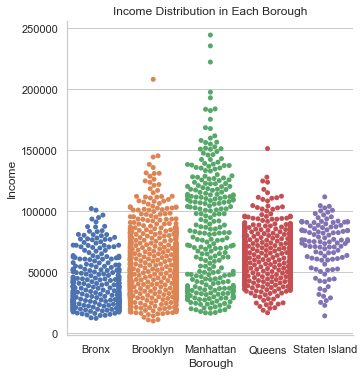

In [82]:
#Let's see the data for income in each Borough.
plt.figure(figsize=(10,15))
sns.catplot(x="Borough", y="Income", kind = 'swarm', data=nyc_df)
plt.title('Income Distribution in Each Borough')

The distribution of income does appear to vary between the boroughs, with Manhattan having the highest income distribution and Staten Island and the Bronx having the lowest of the five boroughs.

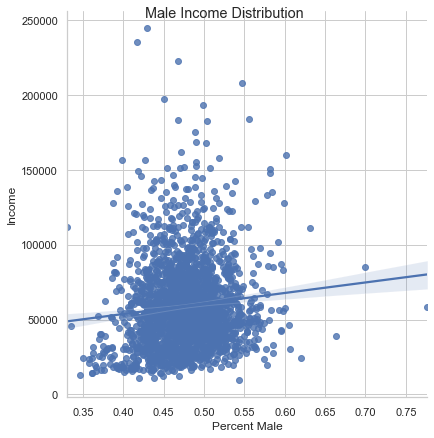

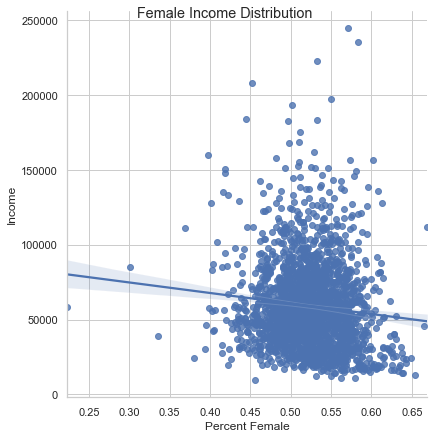

In [59]:
#Let's see if gender has an impact on income
import seaborn as sns

nyc_df['Percent Male'] = nyc_df['Men'] / nyc_df['TotalPop']
nyc_df['Percent Female'] = nyc_df['Women'] / nyc_df['TotalPop']

male_plot = sns.lmplot(x="Percent Male", y="Income",
               truncate=True, height=6, data=nyc_df).fig.suptitle("Male Income Distribution")

female_plot = sns.lmplot(x='Percent Female', y='Income',
               truncate = True, height =6, data=nyc_df).fig.suptitle("Female Income Distribution")

We see a fairly flat line of best fit when using a linear regression plot model, meaning both male and female have a low correlation with Income. There is a very slight positive correlation on the male plot, and a slight negative correlation on the female plot. As a result we can conclude that both of these variables will not be much use in predicting Income.

In [60]:
# Convert boroughs to dummies
nyc_df = pd.get_dummies(nyc_df)
nyc_df.head()

,CensusTract,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,SelfEmployed,FamilyWork,Unemployment,Percent Male,Percent Female,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
1,36005000200,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,...,2.9,0.0,7.7,0.492134,0.507866,1,0,0,0,0
2,36005000400,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,...,2.5,0.6,9.5,0.489603,0.510397,1,0,0,0,0
3,36005001600,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,...,3.8,0.0,8.7,0.435108,0.564892,1,0,0,0,0
4,36005001900,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,...,7.7,0.0,19.2,0.465457,0.534543,1,0,0,0,0
5,36005002000,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,...,7.7,0.0,17.2,0.387623,0.612377,1,0,0,0,0


In [61]:
#Let's take a look at the correlation matrix to see if we want to include any boroughs in the model.

nyc_df.corr()

,CensusTract,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,...,SelfEmployed,FamilyWork,Unemployment,Percent Male,Percent Female,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Queens,Borough_Staten Island
CensusTract,1.000000,-0.039857,-0.018568,-0.057264,-0.342898,0.192393,-0.158930,0.000812,0.347348,0.013088,...,0.065910,0.013164,-0.342252,0.130651,-0.130651,-0.824070,-0.218376,0.095333,0.676703,0.272190
TotalPop,-0.039857,1.000000,0.982715,0.986937,0.185062,-0.022382,-0.099822,-0.033576,-0.015780,0.924217,...,0.060381,0.012287,0.019690,-0.081601,0.081601,0.065474,-0.186167,0.340465,-0.127608,0.043595
Men,-0.018568,0.982715,1.000000,0.940053,0.208436,-0.001702,-0.156635,-0.035618,0.014345,0.889945,...,0.088227,0.015556,-0.014781,0.079018,-0.079018,0.052228,-0.194066,0.333011,-0.107624,0.052209
Women,-0.057264,0.986937,0.940053,1.000000,0.159520,-0.039749,-0.047576,-0.030855,-0.041552,0.928067,...,0.034451,0.009097,0.049134,-0.219085,0.219085,0.075160,-0.174061,0.337382,-0.141412,0.034874
Hispanic,-0.342898,0.185062,0.208436,0.159520,1.000000,-0.490755,-0.150194,-0.003520,-0.178838,-0.015767,...,0.033693,-0.021907,0.335453,0.122533,-0.122533,0.499036,-0.279244,-0.062106,-0.018065,-0.082202
White,0.192393,-0.022382,-0.001702,-0.039749,-0.490755,1.000000,-0.625442,-0.081991,-0.005841,0.153980,...,0.166002,0.057631,-0.503436,0.153871,-0.153871,-0.286997,0.110087,0.196742,-0.133816,0.212684
Black,-0.158930,-0.099822,-0.156635,-0.047576,-0.150194,-0.625442,1.000000,0.017046,-0.436544,-0.095984,...,-0.247895,-0.051444,0.386860,-0.362731,0.362731,0.070122,0.185670,-0.137541,-0.098885,-0.102472
Native,0.000812,-0.033576,-0.035618,-0.030855,-0.003520,-0.081991,0.017046,1.000000,0.059316,-0.044646,...,-0.009870,-0.004558,0.076273,0.004725,-0.004725,0.008120,-0.017002,-0.000140,0.029170,-0.037202
Asian,0.347348,-0.015780,0.014345,-0.041552,-0.178838,-0.005841,-0.436544,0.059316,1.000000,-0.074857,...,0.071868,0.019616,-0.231598,0.184857,-0.184857,-0.254317,-0.113379,-0.029454,0.378688,-0.081262
Citizen,0.013088,0.924217,0.889945,0.928067,-0.015767,0.153980,-0.095984,-0.044646,-0.074857,1.000000,...,0.050888,0.014578,-0.056347,-0.141088,0.141088,-0.007351,-0.183775,0.435869,-0.166246,0.093401


Text(0.5, 0.98, 'Poverty vs Unemployment')

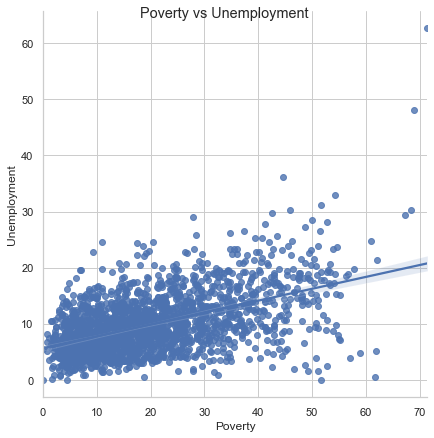

In [62]:
#Intuition tells us there could be a relationship between poverty and unemployment, 
#and these variables could be combined into one feature that represents the relationship. 
#Let's plot them to take a look.

sns.lmplot(x="Poverty", y="Unemployment",
               truncate=True, height=6, data=nyc_df).fig.suptitle("Poverty vs Unemployment")

It is evident there is a positive correlation between Unemployment and Poverty. We will create a new feature that represents the relationship between Poverty and Unemployment to use in our model.

In [63]:
nyc_df['Pov_Unemploy'] = nyc_df['Poverty'] * nyc_df['Unemployment']


After viewing the plots, the correlation matrix, and creating a new feature, I decided to move forward with the models using the Professional, SelfEmployed, Service, Borough_Queens, Production, and the newly created Pov_Unemploy as features.

## Modeling

We will be using the Root Mean Square Error (RMSE) as our criteria to determine which model is the best in this scenario. Reminder a lower RMSE score is desired. This is a good way to check model performance against the test set, or data it has not seen before. It also has an advantage in that it has the same units as our target variable, making results easier to interpret.

In [64]:
# OLS Models - Ridge and Lasso Regression
import statsmodels.api as sm
X = nyc_df[['Pov_Unemploy','Professional','White','SelfEmployed','Service','Borough_Queens','Production']]
Y = nyc_df['Income']
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)
#split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))
Ridge_regr = RidgeCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)
Lasso_regr = LassoCV(alphas=[0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]).fit(X_train, y_train)

The number of observations in training set is 1676
The number of observations in test set is 419


In [65]:
# Ridge Regression

y_preds_train = Ridge_regr.predict(X_train)
y_preds_test = Ridge_regr.predict(X_test)
print("Best alpha value is: {}".format(Ridge_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Ridge_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Ridge_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
Ridge_RMSE = rmse(y_test, y_preds_test)

Best alpha value is: 0.1
R-squared of the model in the training set is: 0.6299114883437221
-----Test set statistics-----
R-squared of the model in the test set is: 0.6726285721685776
Mean absolute error of the prediction is: 12228.211685306129
Mean squared error of the prediction is: 270091479.35738397
Root mean squared error of the prediction is: 16434.46011761214
Mean absolute percentage error of the prediction is: 22.892982367943837


In [66]:
# Lasso Regression

y_preds_train = Lasso_regr.predict(X_train)
y_preds_test = Lasso_regr.predict(X_test)
print("Best alpha value is: {}".format(Lasso_regr.alpha_))
print("R-squared of the model in the training set is: {}".format(Lasso_regr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(Lasso_regr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
Lasso_RMSE = rmse(y_test, y_preds_test)

Best alpha value is: 10.0
R-squared of the model in the training set is: 0.6299107702817287
-----Test set statistics-----
R-squared of the model in the test set is: 0.6726424551530739
Mean absolute error of the prediction is: 12227.522388575317
Mean squared error of the prediction is: 270080025.4689205
Root mean squared error of the prediction is: 16434.111642219075
Mean absolute percentage error of the prediction is: 22.894097766168233


The Lasso and Ridge regression models produced similar scores for their RMSE values, with Ridge having a RMSE of 14603 and Lasso 14601.39.



In [67]:
# Let's try a Random Forest model.
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()

param_grid = { 'max_depth':range(3,7),'n_estimators':[100,200,300,400,500],
                'bootstrap':[True,False]}

forest_grid = GridSearchCV(estimator, param_grid, cv=5, scoring = 'neg_mean_squared_error',verbose=0,n_jobs=-1)
forest_grid.fit(X_train, y_train)
y_pred = forest_grid.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error of the prediction:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Income in Dataset:', np.mean(nyc_df['Income']))
print('The Random Forest Regressor is predicting the median household income at {}%'.format(100*(1 - (metrics.mean_absolute_error(y_test, y_pred))/np.mean(nyc_df['Income']))))
print('Root Mean Squared Error of the prediction:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
Forest_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(RandomForestRegressor.score)

Mean Absolute Error of the prediction: 9832.58383564726
Mean Income in Dataset: 59135.96372315036
The Random Forest Regressor is predicting the median household income at 83.3729202728829%
Root Mean Squared Error of the prediction: 13683.673555170968
<function RegressorMixin.score at 0x7f93ed043ca0>


Text(0.5, 1.0, 'Model RMSE Score')

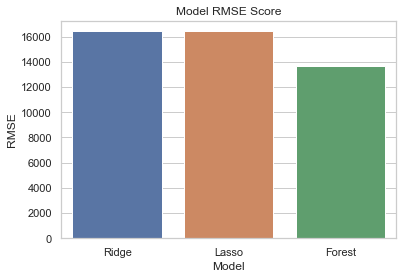

In [68]:
### RMSE illustration for different models to chose the best one for this scenario
from pandas import DataFrame

data = {'Model':['Ridge','Lasso','Forest'],'RMSE':[Ridge_RMSE,Lasso_RMSE,Forest_RMSE]}
Ridge_df = DataFrame(data, columns=['Model','RMSE'])

sns.set(style="whitegrid")
sns.barplot(x="Model", y="RMSE", data=Ridge_df)
plt.title('Model RMSE Score')

The best model based on the RMSE criteria appears to be the Random Forest model, which has an RMSE value that is significantly lower than the Ridge and Lasso regression models.

In [69]:
#Let's do some Cross Validation to see if the model is overfitting
models = [Lasso_regr,Ridge_regr]
from sklearn.model_selection import cross_val_score

for model in models:
        print(cross_val_score(model, X, Y, cv=10))

[ 0.69347205  0.75499312  0.56837935 -0.24299141  0.52131843  0.38779212
  0.34102099  0.01247543  0.24875292  0.30932533]
[ 0.69347275  0.75499413  0.56836906 -0.24301873  0.5213217   0.3877962
  0.339491    0.0247122   0.24876236  0.30935367]


## Future Improvements¶


It is evident from the cross validation that both the Lasso and Ridge models are overfitting, and I believe this could be due to collinearity in the features selected. This could be the reason my random forest model is performing much better as it is more resistant to collinearity in the features. A way to combat this could be to add more data or to do some feature engineering to reduce collinearity.

RF Grid search could be used to select the hyperparameters chosen for the RF Model. This could optimize the parameters and increase model predictive performance.

Additional datasets could be added to the model that show things such as school quality and crime rates, which I believe would be correlated to income of neighborhoods and improve the model predictive performance.